<a href="https://colab.research.google.com/github/jayshrivastava0/Journey-Through-Projects/blob/main/uncertainity_and_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

In [1]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.3.0-py3-none-any.whl size=2117305 sha256=78886f14922199c135f00b222b420b333c067aa0b4c82b72584ae92e965f0d73
  Stored in directory: /root/.cache/pip/wheels/9c/9f/b5/0e31f83bc60a83625e37429f923934e26802d0d68cf3ef3216
Successfully built mitdeeplearning


In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 [==============================] - 26s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [10]:
print(len(images), len(labels))

100 100


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


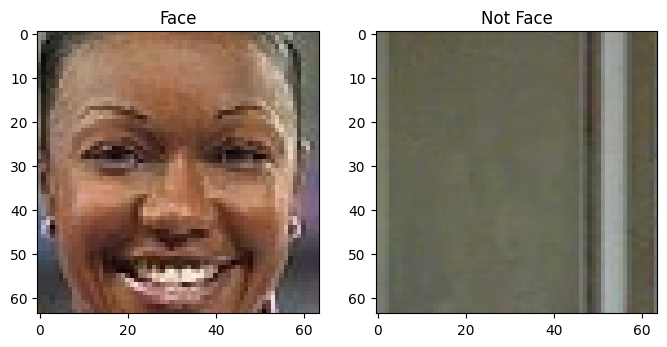

In [7]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

### Examining the CelebA training dataset ###

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 35 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 34 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [11]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()


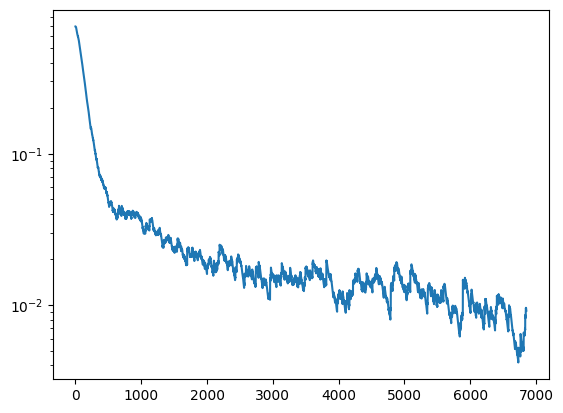

100%|██████████| 3434/3434 [02:45<00:00, 20.69it/s]


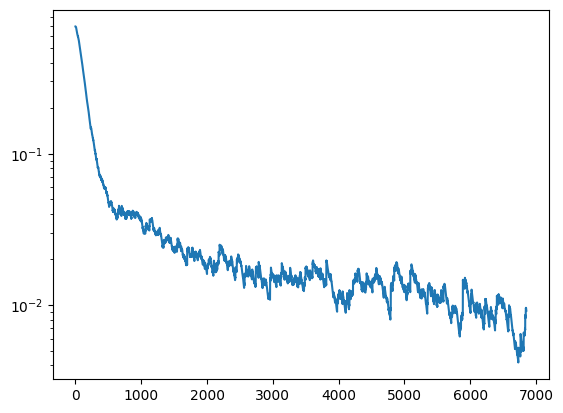

In [12]:
# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())


In [13]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 5s 29ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9964


In [15]:
### Defining the VAE loss function ###
import math
''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise
  # difference between the input and reconstruction. Hint: you'll need to
  # use tf.reduce_mean, and supply an axis argument which specifies which
  # dimensions to reduce over. For example, reconstruction loss needs to average
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss =  kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [16]:
### VAE Sampling ###

"""Sample latent variables via reparameterization with an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

In [17]:
"""Loss function for SS-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: SS-VAE total loss
    classification_loss: SS-VAE classification loss
"""
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss, defined earlier in the lab
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the SS-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss, vae_loss

In [18]:
### Define the decoder portion of the SS-VAE ###

def make_face_decoder_network(n_filters=12):

  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [19]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder (self.decoder) to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: call the sampling function that you created above using
    #       z_mean and z_logsigma
    z = sampling(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

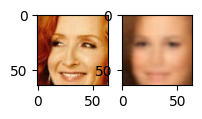

 15%|█▍        | 499/3434 [00:39<03:37, 13.49it/s]

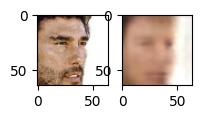

 29%|██▉       | 999/3434 [01:20<03:05, 13.13it/s]

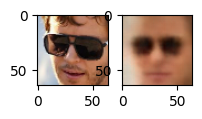

 44%|████▎     | 1500/3434 [02:02<02:28, 13.00it/s]

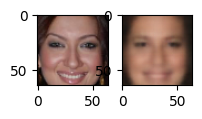

 58%|█████▊    | 1999/3434 [02:43<01:57, 12.18it/s]

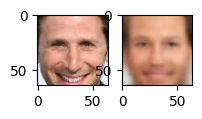

 73%|███████▎  | 2500/3434 [03:25<01:12, 12.82it/s]

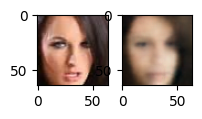

 87%|████████▋ | 2999/3434 [04:06<00:41, 10.58it/s]

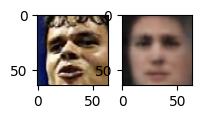

100%|██████████| 3434/3434 [04:42<00:00, 12.16it/s]


In [20]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# SS-VAE needs slightly more epochs to train since its more complex than
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    '''TODO: call the SS_VAE loss function to compute the loss'''
    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = ss_vae_loss_function('''TODO arguments''') # TODO

  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the SS_VAE.'''
  grads = tape.gradient(loss, ss_vae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, ss_vae)

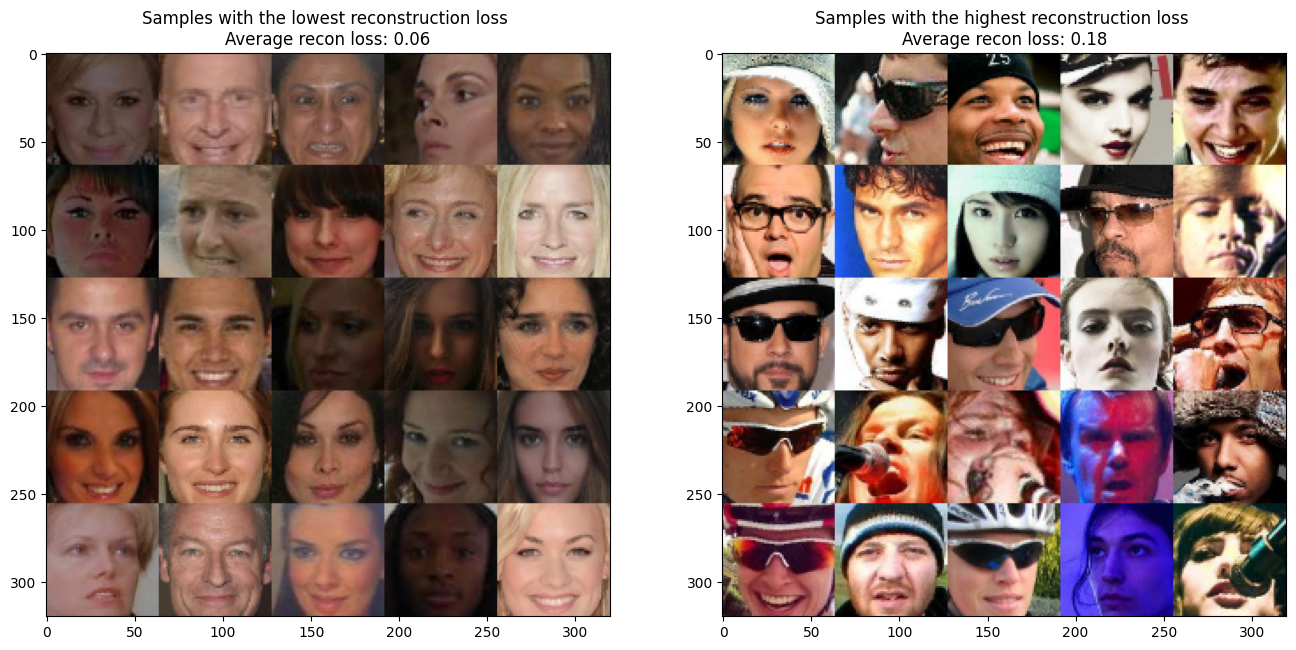

In [21]:
### Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

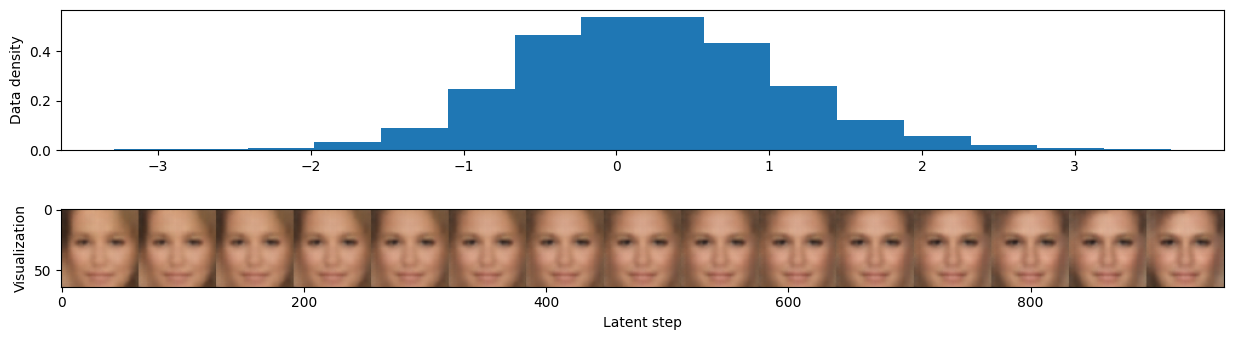

In [22]:
### Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 8 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
  # Adjust the latent vector according to our step
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  # Decode the reconstruction and store
  recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");

Text(0, 0.5, 'Relative accuracy')

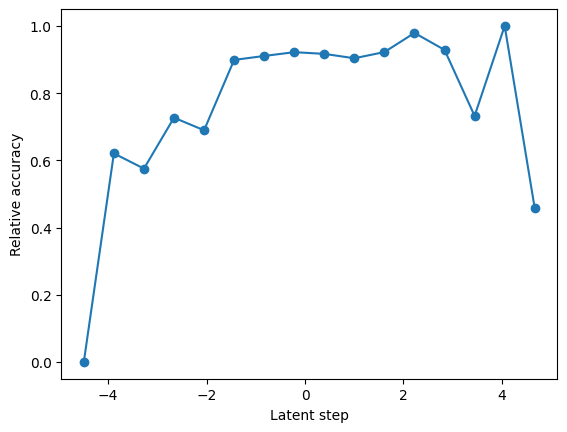

In [23]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  # Find which samples fall in which bin of the latent dimension
  which_latent_bin = np.digitize(latent_samples, latent_steps)

  # For each latent bin, compute the accuracy (average logit score)
  avg_logit = []
  for j in range(0, num_steps+1):
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")